<a href="https://colab.research.google.com/github/AvivNizri/FISH-GAN-VGG19/blob/master/TransferLearningGAN_tfrecords_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fish GAN

Based on ideas from 

https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

https://towardsdatascience.com/dcgans-generating-dog-images-with-tensorflow-and-keras-fb51a1071432

https://medium.com/@jonathan_hui/gan-rsgan-ragan-a-new-generation-of-cost-function-84c5374d3c6e

Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Import Tensorflow

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [(x.name, x.physical_device_desc, f'Memory: {(int)(x.memory_limit/1e6)}MB') for x in local_device_protos if x.device_type == 'GPU']

print(tf.__version__)
get_available_gpus()

TensorFlow 2.x selected.
2.1.0


[('/device:GPU:0',
  'device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5',
  'Memory: 14912MB')]

## Mixed Precision
Mixed precision should speed up the performance of the network training time

https://www.tensorflow.org/guide/keras/mixed_precision

According to NVIDIA, T4 should execute 65 FP16 TFLOPS in mixed precision

* With T4, uising mixed presission looks to reduce epoch training time by ~2.3x factor compareing to not using mixed presission.
* With P100-PCIE-16GB there looks to be none visible difference in taining time.
* T4 with mixed presission looks fasetr than P100 by factor of ~1.23x.

These numbers are relevant when not using the standard "CrossEntropyLoss" but cusom loss function

Note: Later test shows P100 is still faster than T4 by factor of ~1.3 when using mixed precision

In [0]:
use_mixed_precision = True

from tensorflow.keras.mixed_precision import experimental as mixed_precision
if use_mixed_precision:
  policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
  tf.keras.mixed_precision.experimental.set_policy(policy) 
  
  print('Compute dtype: %s' % policy.compute_dtype)
  print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


Import required libraries

In [0]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Activation, ZeroPadding2D, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Lambda
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers

import os
import sys
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import pyplot
from timeit import default_timer as timer

# Global settings

In [0]:
BUFFER_SIZE = 6000
batch_size = 56

image_width = 320
image_height = 140
image_channels = 3

INPUT_SIZE = 1024 #100

image_width_VGG = 224
image_height_VGG = 224

# Data Import

## Map google drive

In [0]:
NotebookPrefix='TransferLearningGAN-V2'

from google.colab import drive
drive.mount('/content/drive')
base_dir = '/content/drive/My Drive/' + NotebookPrefix
raw_images = '/content/drive/My Drive/DeepLearningFishProject/FishCollection'
source_files = '/content/drive/My Drive/DeepLearningFishProject/FishCollectionVGG_TFRecords/*.tfrec'
graph_dir = base_dir + '/graph/'
#source_files = '/content/drive/My Drive/ADL_Project/FishDataset/TFRecords/FishBatch_3*.tfrec'
#source_files = '/kaggle/input/*.tfrec'

base_dir += '/'
images_dir = base_dir +'generated_images/'

if os.path.isdir(images_dir) == False: 
  try:
      os.makedirs(images_dir)
  except OSError:
      print ("Creation of the directory %s failed" % images_dir)
  else:
      print ("Successfully created the directory %s" % images_dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Create TFRecords of images size (224,224,3) - To be fitted to VGG19 Architecture

In [0]:
import cv2
from tqdm import tqdm

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    # If the value is an eager tensor BytesList won't unpack a string from an EagerTensor.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# Create a dictionary with features that may be relevant.
def image_example(image, label):
  feature = {
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image.tostring()),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecord(batch, path, batch_num=0):

    record_file = Target_files + '/FishBatch_%02d.tfrec' % batch_num
    with tf.io.TFRecordWriter(record_file) as writer:
        for image in batch:
            tf_example = image_example(image, 1)
            writer.write(tf_example.SerializeToString())

def convert_images_to_tfrecords(directory, func=None, batch_size=128, limit=sys.maxsize):
    batch_num = 0
    batch_images = []
    for c,i in enumerate(tqdm(os.listdir(directory))):
        path = os.path.join(directory, i)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is not None:
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to RGB
            img = cv2.resize(img, (TARGET_IMG_WIDTH_VGG, TARGET_IMG_HEIGHT_VGG))
            is_success, buffer = cv2.imencode(".png", img)
            #img = func(img) if func else img
            if is_success:
                batch_images.append(buffer)

        if (c+1)%batch_size == 0:
            write_tfrecord(batch_images, directory, batch_num)
            batch_images = []
            batch_num += 1

        if c > limit:
            break
    
    if (c+1)%batch_size == 0:
        write_tfrecord(batch_images, directory, batch_num)

#convert_images_to_tfrecords(source_files, lambda a : (a -127.5) / 127.5)

## Import data

In [0]:
def correct_type(data, target_type=tf.float32):
  #print(type(data))
  if type(data) != np.ndarray and data.dtype != target_type:
    return tf.dtypes.cast(data, target_type)
  return data


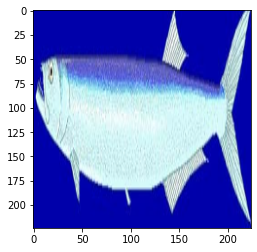

Dataset contains 78 batches
Loading time: 15.314 sec


In [0]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt

def get_dataset(tf_files, shuffle_buffer_size=None, batch_size=None, prefetch=None):
  # get the TFRecord file names from the source directory
  filenames = tf.io.gfile.glob(tf_files)

  # try setup for multiple readers and ignore order
  AUTO = tf.data.experimental.AUTOTUNE
  ignore_order = tf.data.Options()
  ignore_order.experimental_deterministic = False

  # read dataset from the TFRecords
  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(ignore_order)
  dataset = dataset.map(read_tfrecord) # TFRecord decoding here...
  dataset = dataset.cache() # cached dataset (so the png decoding will be done only once)
  if batch_size:
    dataset = dataset.batch(batch_size) # batch the dataset
  if shuffle_buffer_size:
    dataset = dataset.shuffle(shuffle_buffer_size) # use shuffle
  if prefetch:
    dataset = dataset.prefetch(prefetch) # number of records (or batches) to prefetch
  # return the dataset
  return dataset

# read and decode the TFRecord
def read_tfrecord(serialized_example):
  #TFRecord structure (this is custom database)
  feature_description = {
    'label': tf.io.FixedLenFeature((), tf.int64),
    'image_raw': tf.io.FixedLenFeature((), tf.string),
  }
  
  #read a record from the and parse it according to the structure
  example = tf.io.parse_single_example(serialized_example, feature_description)
  # decode the png image into RGB, and cast it to float tensor
  feature1 = tf.cast(tf.io.decode_png(example['image_raw']), dtype=tf.float32)
  #feature1 = tf.cast(tf.io.decode_png(example['image_raw']), dtype=tf.float16)
  # return the image in a [-1, 1] scale
  return (feature1 - 127.5) / 127.5

loading_start_time = timer()

# get the dataset (change list of files of required)
train_dataset = get_dataset(source_files,
                            shuffle_buffer_size=BUFFER_SIZE, 
                            batch_size=batch_size, 
                            prefetch=batch_size)

# disaply the first image in the dataset (this will be random of shuffle is used)
for data in train_dataset.take(1): 
  plt.imshow(correct_type(data)[0, :, :] * 0.5 + 0.5)
  plt.show()

# calculate the number of batches in the dataset (needed later)
NUM_BATCHES = 0
for element in train_dataset:
  NUM_BATCHES += 1
print (f'Dataset contains {NUM_BATCHES} batches')

print('Loading time: %.3f sec' % (timer() - loading_start_time))


# The network
## Network Parameters

In [0]:
# weight parameters
weight_init_std = 0.02
weight_init_mean = 0.0
leaky_relu_slope = 0.2

# dropout rate, set to None to disable dropout
dropout_rate = 0.3

# Optimizer learning rate
lr_initial_d = 0.0002
lr_initial_g = 0.0002
lr_decay_steps = 1000

# latend dim
noise_dim = INPUT_SIZE

# weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=weight_init_std, 
#                                                             mean=weight_init_mean,
#                                                             seed=42)

weight_initializer = tf.keras.initializers.glorot_uniform(seed=7)


## Residual blocks network model

In [0]:
# based on code from:
# https://gist.github.com/mjdietzx/600751b780e1ab2b8802f7788f17882e

use_batch_normalization=True

class ResNet_Constructor:
  def __init__(self, cardinality=1, transposed=False, use_batch_normalization=False, initializer='glorot_uniform', dropout=None):
    """ Constructor class for ResNet blocks
    Arguments:
      * cardinality - (default=1) 
                      Number of parallel convolusions to run.  when cardinality=1, there will be a single standard convolution layer
      * transposed - (default=False)
                      Selecting using Conv2D or Conv2DTranspose
      * use_batch_normalization - (default=False)
                      Select if to add BatchNormalization layers
    """
    self.cardinality=cardinality
    self.transposed=transposed
    self.use_batch_normalization=use_batch_normalization
    self.initializer=initializer
    self.dropout=dropout

  def add_common_layers(self, y):
    if self.use_batch_normalization:
      y = BatchNormalization()(y)
    y = LeakyReLU()(y)
    return y

  def grouped_convolution(self, y, nb_channels, strides):
      # when `cardinality` == 1 this is just a standard convolution
      if self.cardinality == 1:
          if strides != (1, 1) and self.transposed:
              return Conv2DTranspose(nb_channels, kernel_size=(3, 3), strides=strides, padding='same', kernel_initializer=self.initializer)(y)
          else:
              return Conv2D(nb_channels, kernel_size=(3, 3), strides=strides, padding='same', kernel_initializer=self.initializer)(y)

      assert not nb_channels % self.cardinality
      _d = nb_channels // self.cardinality

      # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
      # and convolutions are separately performed within each group
      groups = []
      for j in range(self.cardinality):
          group = Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
          if strides != (1, 1) and self.transposed:
              groups.append(Conv2DTranspose(_d, kernel_size=(3, 3), strides=strides, padding='same', kernel_initializer=self.initializer)(group))
          else:
              groups.append(Conv2D(_d, kernel_size=(3, 3), strides=strides, padding='same', kernel_initializer=self.initializer)(group))

      # the grouped convolutional layer concatenates them as the outputs of the layer
      y = concatenate(groups)

      return y


  def residual_block(self, y, nb_channels_in, nb_channels_out, strides=(1, 1), project_shortcut=False):
      """
      Our network consists of a stack of residual blocks. These blocks have the same topology,
      and are subject to two simple rules:
      - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
      - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        * If up-sampled in case of `transposed` == True, the width of the blocks is divided by a factor of 2.
      """
      shortcut = y

      # we modify the residual building block as a bottleneck design to make the network more economical
      y = Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same', kernel_initializer=self.initializer)(y)
      y = self.add_common_layers(y)

      if self.dropout:
        y = Dropout(self.dropout)(y)
      # ResNeXt (identical to ResNet when `cardinality` == 1)
      y = self.grouped_convolution(y, nb_channels_in, strides=strides)
      y = self.add_common_layers(y)

      y = Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same', kernel_initializer=self.initializer)(y)
      # batch normalization is employed after aggregating the transformations and before adding to the shortcut
      if self.use_batch_normalization:
        y = BatchNormalization()(y)

      # identity shortcuts used directly when the input and output are of the same dimensions
      if project_shortcut or strides != (1, 1):
          # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
          # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
          if strides != (1, 1) and self.transposed:
              shortcut = Conv2DTranspose(nb_channels_out, kernel_size=(1, 1), strides=strides, padding='same', kernel_initializer=self.initializer)(shortcut)
          else:
              shortcut = Conv2D(nb_channels_out, kernel_size=(1, 1), strides=strides, padding='same', kernel_initializer=self.initializer)(shortcut)
          if self.use_batch_normalization:
            shortcut = BatchNormalization()(shortcut)

      y = add([shortcut, y])

      # relu is performed right after each batch normalization,
      # expect for the output of the block where relu is performed after the adding to the shortcut
      y = LeakyReLU()(y)

      return y

  def conv_block(self, x, nb_channels_in, nb_channels_out):
      for i in range(2):
          strides = (2, 2) if i == 0 else (1, 1)
          x = self.residual_block(x, nb_channels_in, nb_channels_out, strides=strides)
      return x

  def stack_blocks(self, x, filters=64):
      # conv2
      x = self.conv_block(x, filters, filters*4)
      # conv3
      filters *= 2
      x = self.conv_block(x, filters, filters*4)
      # conv4
      filters *= 2
      x = self.conv_block(x, filters, filters*4)
      # conv5
      filters *= 2
      x = self.conv_block(x, filters, filters*4)

      return x

  def reduce_top_line(self, y, nb_channels_out):
    y = Conv2D(nb_channels_out, kernel_size=(2, 1), strides=(1, 1), padding='valid', kernel_initializer=self.initializer)(y)
    y = self.add_common_layers(y)
    return y

In [0]:
def create_generator(latent_dim, filters=64, initializer='glorot_uniform'):

  def generator_network(x, filters, initializer):
    constructor = ResNet_Constructor(transposed=True, use_batch_normalization=use_batch_normalization, initializer=initializer, dropout=dropout_rate)

    x = Dense(filters * 5 * 10)(x)
    x = constructor.add_common_layers(x)

    x = Reshape((5, 10, filters))(x)

    # conv2 
    x = constructor.conv_block(x, filters, filters*4)
    # reduce top line
    x = constructor.reduce_top_line(x, filters*4)
    # conv3
    filters = (int)(filters / 2)
    x = constructor.conv_block(x, filters, filters*4)
    # conv4
    filters = (int)(filters / 2)
    x = constructor.conv_block(x, filters, filters*4)
    # reduce top line
    x = constructor.reduce_top_line(x, filters*4)
    # conv5
    filters = (int)(filters / 2)
    x = constructor.conv_block(x, filters, filters*4)

    # (conv1 disc)
    # number of feature maps => number of image channels
    return Conv2DTranspose(image_channels, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='tanh', dtype='float32')(x)

  filters *= 2 ** 3 # will b reduced in to the original requested filters on the last layer

  generator_input_tensor = Input(shape=latent_dim) # maybe shape=(1,1,latent_dim)
  generated_image_tensor = generator_network(generator_input_tensor, filters, initializer)

  generator_model = Model(inputs=[generator_input_tensor], 
                          outputs=[generated_image_tensor], 
                          name='Generator_ResNet')

  print(generator_model.summary())
  return generator_model

In [0]:
# this function responsible for the last layers (fine-tune) of the transfered learning model 
def build_classification_layers(new_output_model):

    #Flatten layer flattens the output of the previous layer to a single dimension.
    new_output_model.add(Flatten())
    #Outputs a value between 0 and 1 that predicts whether image is real or generated. 0 = generated, 1 = real.
    new_output_model.add(Dense(32, activation='relu'))
    new_output_model.add(Dropout(0.25))

    new_output_model.add(Dense(1))
    new_output_model.add(Activation("sigmoid", dtype='float32'))

    # opt = Adam(lr=0.0002, beta_1=0.5)
    # opt = mixed_precision.LossScaleOptimizer(opt, loss_scale='dynamic') # for float16 precision

    # new_output_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return new_output_model

In [0]:
def define_discriminator_VGG1(in_shape=(image_height_VGG,image_width_VGG, image_channels), filters=64):
    final_model = Sequential(name = 'denseLayers1')

    base_model = VGG19(include_top=False, weights='imagenet', input_shape=in_shape)
    # we are adding the layer in this way cause the 'base_model' is returning a keras.engine.training.model type
    # which is not sequantial type in order to do the fine tune at the last layers
    for layer in base_model.layers:
        final_model.add(layer)

    # than we Freeze the layers which we don't want to train. Here I am freezing the last 3 layers -> the Dense and the last convolutional
    #for layer in final_model.layers[:-3]:
    for layer in final_model.layers:
        layer.trainable = False

    final_model = build_classification_layers(final_model)   
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    opt = mixed_precision.LossScaleOptimizer(opt, loss_scale='dynamic') # for float16 precision

    final_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    #final_model.summary()

    return final_model

In [0]:
def define_discriminator_VGG2(in_shape=(image_height_VGG,image_width_VGG, image_channels), filters=64):

    classification_model = Sequential(name = 'denseLayers2')

    vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=in_shape)
    # than we Freeze the layers which we don't want to train. Here I am freezing the last 3 layers -> the Dense and the last convolutional
    # for layer in vgg19.layers[:-3]:
    #     layer.trainable = False 
    vgg19.trainable = False

    classification_model = build_classification_layers(classification_model)   
    
    final_model = tf.keras.Model(inputs=vgg19.input, outputs=classification_model(vgg19.output))

    opt = Adam(lr=0.0002, beta_1=0.5)
    opt = mixed_precision.LossScaleOptimizer(opt, loss_scale='dynamic') # for float16 precision

    final_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    #final_model.summary()

    return final_model

In [0]:
def define_discriminator_VGG3(in_shape=(image_height_VGG,image_width_VGG, image_channels), filters=64):

    model = VGG19(include_top=False, weights='imagenet', input_shape=in_shape)
    # than we Freeze the layers which we don't want to train. Here I am freezing the first 5 layers -> the Dense and the last convolutional
    for layer in model.layers[:-1]:
        layer.trainable = False 

    #Adding custom Layers 
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(1)(x)
    predictions = tf.keras.layers.Activation("sigmoid", dtype='float32')(x)
    
    # creating the final model 
    model_final = tf.keras.Model(inputs = model.input, outputs = predictions)

    opt = Adam(lr=0.0002, beta_1=0.5)
    opt = mixed_precision.LossScaleOptimizer(opt, loss_scale='dynamic') # for float16 precision

    model_final.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    #model_final.summary()

    return model_final

In [0]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

in_shape=(image_height_VGG,image_width_VGG, image_channels)

def create_discriminator(num):
    if num == 1:
        return define_discriminator_VGG1()
    if num == 2 :
        return define_discriminator_VGG2()
    else:
        return define_discriminator_VGG3()

#create_discriminator()

## Another Generator Model

In [0]:
def define_generator(latent_dim, filters=512):
    #Generator attempts to fool discriminator by generating new images.
    model = Sequential(name='Generator')

    # Initializer = Xavier uniform
    init=tf.keras.initializers.glorot_uniform(seed=7)

    # foundation for 10x10 image
    n_nodes = filters * 10 * 10
    model.add(Dense(n_nodes ,input_dim=latent_dim, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((10,10,filters)))

    def add_conv_layer(model, filters=1024, upsample_size=(2,2), kernel_size=3, batch_norm=True, padding='same'):
        # if padding == 'valid':
        #   model.add(UpSampling2D(size=upsample_size))
        #   model.add(ZeroPadding2D(padding=(0,1)))
        #   model.add(Conv2D(filters,kernel_size=kernel_size,padding=padding))
        # else:
        model.add(Conv2DTranspose(filters,kernel_size=kernel_size,strides=upsample_size,padding=padding, use_bias=False, kernel_initializer=init))
        if batch_norm:
            model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
    

    # upsample to 20x20
    add_conv_layer(model, kernel_size=7, filters=filters) 
    
    filters = (int)(filters/2)
    # upsample to 40x40
    add_conv_layer(model, filters=filters) 
    
    # strip 4 lines (2 from the top and 2 from bottom)
    model.add(ZeroPadding2D(padding=(0,2)))
    model.add(Conv2D(filters,kernel_size=5,padding='valid', use_bias=False, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 36x80
    add_conv_layer(model, filters=filters, upsample_size=(1,2)) 
    # upsample to 72x160
    add_conv_layer(model, filters=filters) 
    # strip 2 lines (1 from the top and 1 from bottom)
    model.add(ZeroPadding2D(padding=(0,1)))
    model.add(Conv2D(filters,kernel_size=3,padding='valid', use_bias=False, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 140x320
    filters = (int)(filters/2)
    add_conv_layer(model, filters=filters) 
    # Last convolutional layer outputs as many featuremaps as channels in the final image.
    model.add(Conv2D(3,kernel_size=5,padding="same", use_bias=False, kernel_initializer=init))
    # tanh maps everything to a range between -1 and 1.
    model.add(Activation("tanh", dtype='float32'))

    # show the summary of the model architecture
    model.summary()
    return model

# Loss and Optimizers

## Loss functions

Following Loss functions are implemented:
* GAN - Using BinaryCrossentropy
* LSGAN - Least Squares
* RaLSGAN - Relativistic Average Least Squares
* RaSGAN - Relativistic Average Standard
* RaHinge - Relativistic Hinge loss


Note on tf.keras.losses.Reduction:
https://www.tensorflow.org/api_docs/python/tf/keras/losses/Reduction

In [0]:
# common functionality of loss classes
class BaseLoss(tf.keras.losses.Loss):
  def __init__(self, name, apply_label_smoothing, loss_func):
    super().__init__(reduction=tf.keras.losses.Reduction.AUTO, 
                     name=name)
    self.apply_label_smoothing = apply_label_smoothing
    self.loss_func = loss_func
    self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    loss_funcs = {'gan': self.gan_loss,
                  'ralsgan': self.ralsgan_loss,
                  'lsgan': self.lsgan_loss,
                  'rasgan': self.rasgan_loss,
                  'rahinge': self.rasgan_loss}

    self.loss_f = loss_funcs[loss_func]
  
  # Label smoothing -- technique from GAN hacks, instead of assigning 1/0 as class labels, we assign a random integer in range [0.7, 1.0] for positive class
  # and [0.0, 0.3] for negative class
  @staticmethod
  @tf.function
  def smooth_positive_labels(y):
      return y - 0.3 + (np.random.random(y.shape) * 0.5)

  @staticmethod
  @tf.function
  def smooth_negative_labels(y):
      return y + np.random.random(y.shape) * 0.3

  # Randomly flip labels to introduce more noise to the discriminator
  @staticmethod
  @tf.function
  def noisy_labels(y, p_flip):
      # determine the number of labels to flip
      n_select = int(p_flip * int(y.shape[0]))
      # choose labels to flip
      flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)
      
      op_list = []
      # invert the labels in place
      #y_np[flip_ix] = 1 - y_np[flip_ix]
      for i in range(int(y.shape[0])):
          if i in flip_ix:
              op_list.append(tf.subtract(1.0, y[i]))
          else:
              op_list.append(y[i])
      
      outputs = tf.stack(op_list)
      return outputs

### Discriminator Loss ###
class DiscriminatorLoss(BaseLoss):
  """ Discriminator Loss function object
  Arguments:
    apply_label_smoothing: make the labels a bit "noisy" but still in the same area
    label_noise: randomly flip 5% of the labels
    loss_func: loss function to use options are:
        * gan (default) - Using BinaryCrossentropy
        * ralsgan
        * lsgan
        * rasgan
        * rahinge
  """
  def __init__(self, apply_label_smoothing=True, label_noise=False, loss_func='gan'):
    super().__init__(name='Dloss_' + loss_func,
                     apply_label_smoothing=apply_label_smoothing,
                     loss_func=loss_func)
    self.label_noise = label_noise

  @tf.function
  def gan_loss(self, real_output, real_y, fake_output, fake_y):
    real_loss = self.cross_entropy(tf.ones_like(real_output), real_y)
    fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_y)
    return real_loss + fake_loss

  @tf.function
  def lsgan_loss(self, real_output, fake_output):
    return (tf.math.reduce_mean(tf.math.square(real_output - 0)) 
          + tf.math.reduce_mean(tf.math.square(fake_output - 1)))

  @tf.function
  def ralsgan_loss(self, real_output, fake_output):
    return (tf.math.reduce_mean(tf.math.square(real_output - tf.math.reduce_mean(fake_output) - tf.ones_like(real_output)))
          + tf.math.reduce_mean(tf.math.square(fake_output - tf.math.reduce_mean(real_output) + tf.ones_like(fake_output)))) / 2.

  @tf.function
  def rasgan_loss(self, real_output, fake_output):
    avg_fake_logit = tf.math.reduce_mean(fake_output)
    avg_real_logit = tf.math.reduce_mean(real_output)
    D_r_tilde = tf.nn.sigmoid(real_output - avg_fake_logit)
    D_f_tilde = tf.nn.sigmoid(fake_output - avg_real_logit)
    return - tf.math.reduce_mean(tf.math.log(D_r_tilde + 1e-14)) - tf.math.reduce_mean(tf.math.log(1 - D_f_tilde + 1e-14))

  @tf.function
  def rahinge_loss(self, real_output, fake_output):
    real_loss = tf.math.reduce_mean(tf.nn.relu(tf.ones_like(real_output) - (real_output - tf.math.reduce_mean(fake_output))))
    fake_loss = tf.math.reduce_mean(tf.nn.relu(tf.ones_like(fake_output) + (fake_output - tf.math.reduce_mean(real_output))))
    return real_loss + fake_loss

  @tf.function
  def call(self, y_real, y_fake):
    real_output = y_real
    fake_output = y_fake
    # apply noise
    if self.label_noise:
      real_output = BaseLoss.noisy_labels(tf.ones_like(real_output), 0.05)   
      fake_output = BaseLoss.noisy_labels(tf.zeros_like(fake_output), 0.05)
    # apply smoothing 
    if self.apply_label_smoothing:
      real_output = BaseLoss.smooth_positive_labels(real_output)
      fake_output = BaseLoss.smooth_negative_labels(fake_output)

    if self.loss_func == 'gan': 
      return self.loss_f(real_output, y_real, fake_output, y_fake) # gan has different parameters

    return self.loss_f(real_output, fake_output)

### Generator Loss ###
class GeneratorLoss(BaseLoss):
  """ Generator Loss function object
  Arguments:
    apply_label_smoothing: make the labels a bit "noisy" but still in the same area
    loss_func: loss function to use options are:
        - gan (default)
        - ralsgan
        - lsgan
        - rasgan
        - rahinge
  """
  def __init__(self, apply_label_smoothing=True, loss_func='gan'):
    super().__init__(name='Dloss_' + loss_func,
                  apply_label_smoothing=apply_label_smoothing,
                  loss_func=loss_func)

  @tf.function
  def gan_loss(self, fake_output, fake_y):
    return  self.cross_entropy(tf.ones_like(fake_output), fake_y)

  @tf.function
  def lsgan_loss(self, real_output, fake_output):
    return (tf.math.reduce_mean(tf.math.square(fake_output - 0))) 
  
  @tf.function
  def ralsgan_loss(self, real_output, fake_output):
    return (tf.math.reduce_mean(tf.math.square(real_output - tf.math.reduce_mean(fake_output) + tf.ones_like(real_output)))
          + tf.math.reduce_mean(tf.math.square(fake_output - tf.math.reduce_mean(real_output) - tf.ones_like(fake_output)))) / 2.

  @tf.function
  def rasgan_loss(self, real_output, fake_output):
    avg_fake_logit = tf.math.reduce_mean(fake_output)
    avg_real_logit = tf.math.reduce_mean(real_output)
    D_r_tilde = tf.nn.sigmoid(real_output - avg_fake_logit)
    D_f_tilde = tf.nn.sigmoid(fake_output - avg_real_logit)
    total_loss = - tf.math.reduce_mean(tf.math.log(D_f_tilde + 1e-14)) - tf.math.reduce_mean(tf.math.log(1 - D_r_tilde + 1e-14))
    return total_loss

  @tf.function
  def rahinge_loss(self, real_output, fake_output):
      fake_loss = tf.math.reduce_mean(tf.nn.relu(tf.ones_like(fake_output) - (fake_output - tf.math.reduce_mean(real_output))))
      real_loss = tf.math.reduce_mean(tf.nn.relu(tf.ones_like(real_output) + (real_output - tf.math.reduce_mean(fake_output))))
      return fake_loss + real_loss

  @tf.function
  def call(self, y_real, y_fake):
    real_output = y_real
    fake_output = y_fake
    # apply smoothing 
    if self.apply_label_smoothing:
      fake_output = BaseLoss.smooth_negative_labels(fake_output)

    if self.loss_func == 'gan': 
      return self.loss_f(fake_output, y_fake) # gan has different parameters
    
    return self.loss_f(real_output, fake_output)


## Create loss function and Optimizers

In [0]:
### Loss function definition ###
# use one of the following as value to 'loss_func':
# gan
# ralsgan 
# lsgan
# rasgan
# rahinge

#loss_func='lsgan'
loss_func='gan' # using BCE loss

disc_loss_func = DiscriminatorLoss(loss_func=loss_func, label_noise=False)
gen_loss_func = GeneratorLoss(loss_func=loss_func)

### Optimizers ###
generator_optimizer = Adam(learning_rate=lr_initial_g, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=lr_initial_d, beta_1=0.5)

if use_mixed_precision:
  generator_optimizer = mixed_precision.LossScaleOptimizer(generator_optimizer, loss_scale='dynamic') # for float16 precision
  discriminator_optimizer = mixed_precision.LossScaleOptimizer(discriminator_optimizer, loss_scale='dynamic') # for float16 precision

# Train Code

In [0]:
# function to rescale batch to size of 224*224
def scale_for_vgg(batch):
    #for image in batch:
    batch = tf.image.resize(batch, (image_width_VGG, image_height_VGG))
    return batch

## Utility functions

In [0]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=1, show=False, copy_to_local=False):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(correct_type(examples[i]))
  # save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	if show:
		pyplot.show()
	pyplot.close()
	if copy_to_local:
		dest = images_dir + filename
		with open(filename, 'rb') as src, open(dest, 'wb') as dst: dst.write(src.read())

# save the models in h5 format  
def save_models(epoch, g_model, d_model=None, gan_model=None):
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)
	if gan_model:
		filename = 'discriminator_model_%03d.h5' % (epoch+1)
		d_model.save(filename)
	if gan_model:
		filename = 'gan_model_%03d.h5' % (epoch+1)
		gan_model.save(filename)

# function by Nanashi
def plot_loss(G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  return tf.random.normal([n_samples, latent_dim])

# return real images with labels of 1
def generate_real_samples(images_batch):
	X = images_batch
	y = ones((len(images_batch), 1))
	return X, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1)) 
	return X, y

# custom evaluation function
def evaluate_model_accuracy(model, x, y):
	test_accuracy = tf.keras.metrics.BinaryAccuracy()
	prediction = model(x, training=False)
	test_accuracy(y, prediction)
	return test_accuracy.result()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, show_plot=False):
	
	# prepare real samples
	for image_batch in dataset.skip(randint(0, NUM_BATCHES - 1)).take(2):
		X_real, y_real = generate_real_samples(image_batch)
	
	# evaluate discriminator on real examples
	acc_real = evaluate_model_accuracy(d_model, X_real, y_real) 
	
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, len(image_batch))
	x_fake_in_proper_scale = x_fake
	x_fake = scale_for_vgg(x_fake)
 
	# evaluate discriminator on fake examples
	acc_fake = evaluate_model_accuracy(d_model, x_fake, y_fake)
	
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	
	# save plot
	save_plot(x_fake_in_proper_scale, epoch, 1, show_plot, copy_to_local=True)
	save_models(epoch, g_model)
	return acc_real, acc_fake

## Train Function

In [0]:
### Train step function ###
@tf.function
def train_step(images, g_model, d_model, latent_dim):
    """ Train step for batch of images
    Arguments:
      images: real images to tarin on
      g_model: generator model
      d_model: discriminator model
      latent_dim: size of "noise" vector
    """
    # create noise tensor to be used for the generator input
    noise = generate_latent_points(latent_dim, len(images))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generate fake images
        generated_images = g_model(noise, training=True)
        generated_images = scale_for_vgg(generated_images)
        
        # get verdict of discriminator on real and fake images
        real_output = d_model(images, training=True)
        fake_output = d_model(generated_images, training=True)
        
        # calculate loss of generator and discriminator
        gen_loss = gen_loss_func(real_output, fake_output)
        disc_loss = disc_loss_func(real_output, fake_output)
    
    # calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, g_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, d_model.trainable_variables)

    # apply gradients to model params (using optimizer function)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, g_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, d_model.trainable_variables))

    return disc_loss, gen_loss

In [0]:
def train(dataset, g_model, d_model, latent_dim, epochs, epoch_start=0):
    print('Start training...')
    summarize_performance(0, g_model, d_model, dataset, latent_dim, True)

    G_loss = []
    D_loss = []
    for epoch in range(epoch_start, epochs):
        # epoch train        
        start = timer()
        new_lr_d = lr_initial_d
        new_lr_g = lr_initial_g
        global_step = 0
        
        # run on all the batches
        for image_batch in dataset:
            d_loss, g_loss = train_step(image_batch, g_model, d_model, latent_dim)
            D_loss.append(d_loss)
            G_loss.append(g_loss)
            global_step = global_step + 1

        print('Epoch %d time: %.3f sec  Loss: d=%.3f g=%.3f' % 
				(epoch + 1, timer() - start, np.mean(D_loss), np.mean(G_loss)))

        #display.clear_output(wait=True)

        # check accuracy and save checkpoints
        if (epoch + 1) % 10 == 0:
          summarize_performance(epoch, g_model, d_model, dataset, latent_dim, True)
          # save checkpoint
          checkpoint_manager.save()

        if (epoch + 1) % 200 == 0:
            print('Reducing learning rate..')
            new_lr_d = tf.compat.v1.train.cosine_decay(new_lr_d, min(global_step, lr_decay_steps), lr_decay_steps)
            new_lr_g = tf.compat.v1.train.cosine_decay(new_lr_g, min(global_step, lr_decay_steps), lr_decay_steps)
            generator_optimizer = Adam(learning_rate=new_lr_d, beta_1=0.5)
            discriminator_optimizer = Adam(learning_rate=new_lr_g, beta_1=0.5)
            
        # clear the loss history        
        G_loss = []
        D_loss = []           
  
    print('End of Training.')

# Train the network

In [0]:
# size of the latent space
latent_dim = INPUT_SIZE

# create the generator
#g_model = define_generator(latent_dim, 128)

#fish_generator = FishGenerator()
g_model = create_generator(latent_dim, filters=64) #, initializer=weight_initializer)

# There are 3 Discriminator Architectures choose : create_discriminator( 1 / 2 / 3 )
d_model = create_discriminator(3)
d_model.summary()

gan_model = None

Model: "Generator_ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 25600)        26240000    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 25600)        102400      dense[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 25600)        0           batch_normalization[0][0]        
___________________________________________________________________________________

## Save model graph

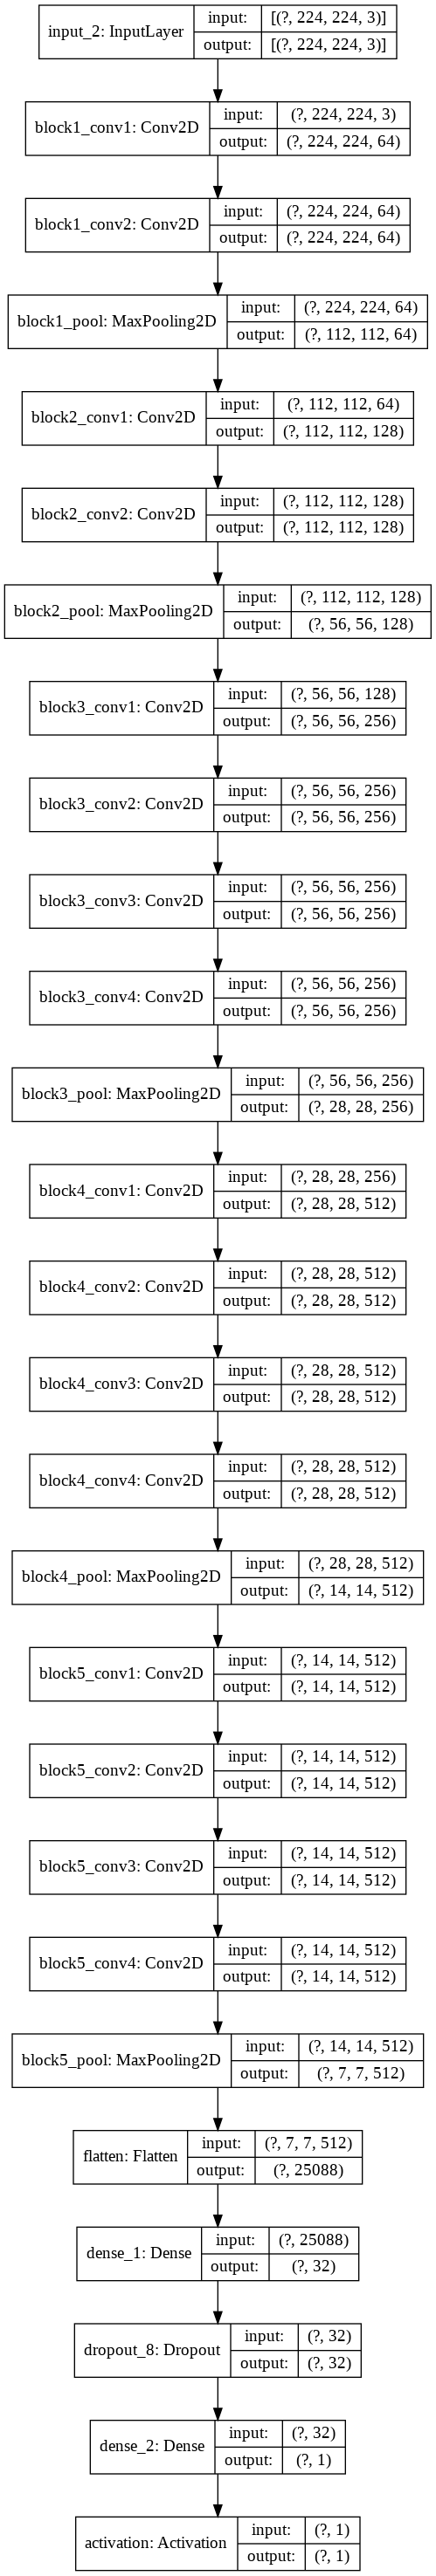

In [0]:
tf.keras.utils.plot_model(g_model, to_file=graph_dir + 'generator_model_plot.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(d_model, to_file=graph_dir + 'discriminator_model_plot.png', show_shapes=True, show_layer_names=True)
# if gan_model:
#  tf.keras.utils.plot_model(gan_model, to_file=graph_dir + 'gan_model_plot.png', show_shapes=True, show_layer_names=True)

## Checkpoint - Restore last checkpoint
Restore the last checkpoint from (google drive?)
this will create checkpoint_manager that is used to save and restore the checkpoints.
max_keep is set to 5 to prevent from blowing up the storage

In [0]:
import re
# store checkpoints (in google drive)
checkpoint_dir = base_dir + '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
if gan_model:
  checkpoint = tf.train.Checkpoint(g_model=g_model,
                                  d_model=d_model,
                                  gan_model=gan_model)
else:
  checkpoint = tf.train.Checkpoint(g_model=g_model,
                                  d_model=d_model)

checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

checkpoint.restore(checkpoint_manager.latest_checkpoint)

if checkpoint_manager.latest_checkpoint:
  print("Restored from {}".format(checkpoint_manager.latest_checkpoint))
  cpfile=checkpoint_manager.latest_checkpoint
  first_epoch = int(re.findall(r'\d+', cpfile[cpfile.rfind('/') + 1:])[0])
  first_epoch *= 10 # saving checkpoint every 10 epoches
  print(f'Setting first epoch to {first_epoch}')
else:
  print("Initializing from scratch.")
  first_epoch = 0

Initializing from scratch.


## Training Loop

Start training...
>Accuracy real: 7%, fake: 100%


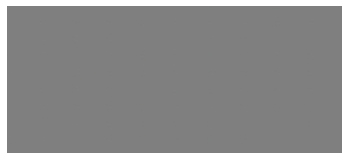

Epoch 1 time: 180.754 sec  Loss: d=11.340 g=0.983
Epoch 2 time: 154.825 sec  Loss: d=15.249 g=0.000
Epoch 3 time: 154.799 sec  Loss: d=15.249 g=0.000
Epoch 4 time: 154.782 sec  Loss: d=15.249 g=0.000
Epoch 5 time: 154.784 sec  Loss: d=15.249 g=0.000
Epoch 6 time: 154.804 sec  Loss: d=15.249 g=0.000
Epoch 7 time: 154.680 sec  Loss: d=15.249 g=0.000
Epoch 8 time: 154.865 sec  Loss: d=15.249 g=0.000
Epoch 9 time: 154.780 sec  Loss: d=15.249 g=0.000
Epoch 10 time: 154.783 sec  Loss: d=15.249 g=0.000
>Accuracy real: 100%, fake: 0%


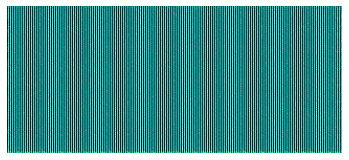

Epoch 11 time: 154.749 sec  Loss: d=15.249 g=0.000
Epoch 12 time: 154.970 sec  Loss: d=15.249 g=0.000
Epoch 13 time: 154.958 sec  Loss: d=15.249 g=0.000
Epoch 14 time: 154.683 sec  Loss: d=15.249 g=0.000
Epoch 15 time: 154.701 sec  Loss: d=15.249 g=0.000
Epoch 16 time: 154.759 sec  Loss: d=15.249 g=0.000
Epoch 17 time: 154.843 sec  Loss: d=15.249 g=0.000
Epoch 18 time: 154.764 sec  Loss: d=15.249 g=0.000
Epoch 19 time: 154.689 sec  Loss: d=15.249 g=0.000
Epoch 20 time: 154.819 sec  Loss: d=15.249 g=0.000
>Accuracy real: 100%, fake: 0%


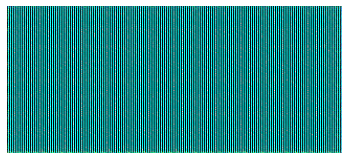

Epoch 21 time: 155.012 sec  Loss: d=15.249 g=0.000
Epoch 22 time: 155.010 sec  Loss: d=15.249 g=0.000
Epoch 23 time: 154.807 sec  Loss: d=15.249 g=0.000
Epoch 24 time: 154.771 sec  Loss: d=15.249 g=0.000
Epoch 25 time: 154.739 sec  Loss: d=15.249 g=0.000
Epoch 26 time: 154.669 sec  Loss: d=15.249 g=0.000
Epoch 27 time: 154.765 sec  Loss: d=15.249 g=0.000
Epoch 28 time: 154.580 sec  Loss: d=15.249 g=0.000
Epoch 29 time: 154.830 sec  Loss: d=15.249 g=0.000
Epoch 30 time: 154.921 sec  Loss: d=15.249 g=0.000
>Accuracy real: 100%, fake: 0%


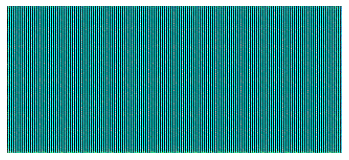

Epoch 31 time: 155.211 sec  Loss: d=15.249 g=0.000
Epoch 32 time: 154.742 sec  Loss: d=15.249 g=0.000
Epoch 33 time: 154.714 sec  Loss: d=15.249 g=0.000
Epoch 34 time: 154.762 sec  Loss: d=15.249 g=0.000
Epoch 35 time: 154.753 sec  Loss: d=15.249 g=0.000
Epoch 36 time: 154.801 sec  Loss: d=15.249 g=0.000
Epoch 37 time: 154.817 sec  Loss: d=15.249 g=0.000
Epoch 38 time: 154.828 sec  Loss: d=15.249 g=0.000
Epoch 39 time: 154.922 sec  Loss: d=15.249 g=0.000
Epoch 40 time: 154.693 sec  Loss: d=15.249 g=0.000
>Accuracy real: 100%, fake: 0%


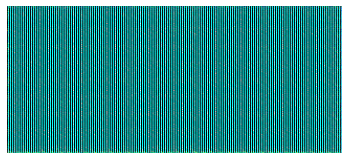

Epoch 41 time: 155.027 sec  Loss: d=15.249 g=0.000
Epoch 42 time: 154.802 sec  Loss: d=15.249 g=0.000
Epoch 43 time: 154.694 sec  Loss: d=15.249 g=0.000
Epoch 44 time: 154.771 sec  Loss: d=15.249 g=0.000
Epoch 45 time: 154.888 sec  Loss: d=15.249 g=0.000


KeyboardInterrupt: ignored

In [0]:
# train model
# EPOCHES = 1000 # run until good enough results
# train(g_model, d_model, gan_model, train_dataset, latent_dim, EPOCHES, first_epoch)

EPOCHES = 750
train(train_dataset, g_model, d_model, INPUT_SIZE, EPOCHES, first_epoch)

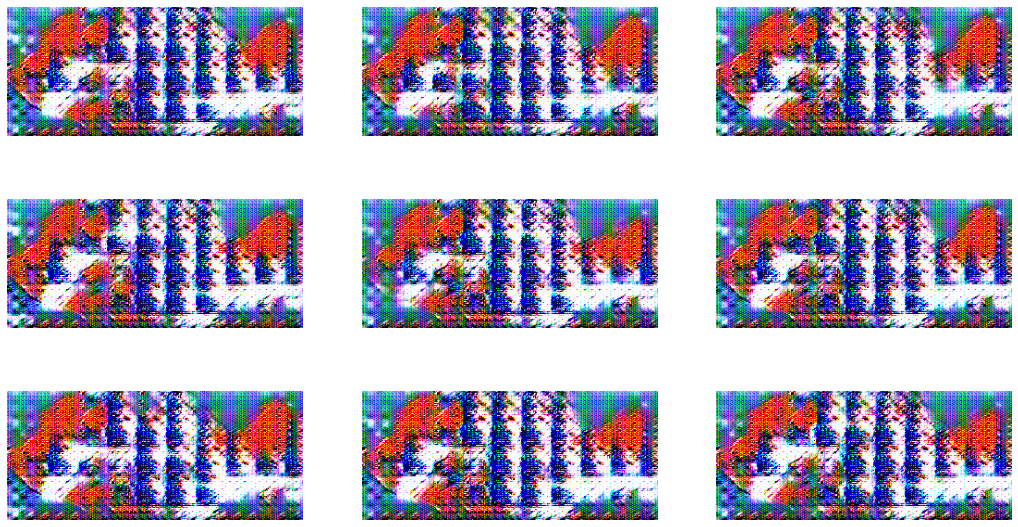

In [0]:
# generate and show samples
def gen_and_show(row_samples, col_samples):
    x_fake, _ = generate_fake_samples(g_model, latent_dim=INPUT_SIZE, n_samples=row_samples*col_samples)

    fig = plt.figure(figsize=(18,10))
    
    for i in range(x_fake.shape[0]):
        plt.subplot(row_samples, col_samples, i+1)
        plt.imshow(x_fake[i, :, :] * 0.5 + 0.5)
        plt.axis('off')

    plt.show()

gen_and_show(3, 3)


# Remove **ALL** generated files

In [0]:
import ipywidgets as widgets
from IPython.display import display
button = widgets.Button(description="Delete Stored files!", icon="", button_style='warning')
output = widgets.Output()

def on_button_clicked(b):
  !rm -rf generated_plot_e*
  !rm -rf generator_model_*.h5
  !rm -rf discriminator_model_*.h5
  with output:
    print("Files deleted!")

button.on_click(on_button_clicked)
display(button, output)

In [0]:
import ipywidgets as widgets
from IPython.display import display
checkpoints_clear_button = widgets.Button(description="Delete checkpoints files!", icon="", button_style='warning')
output = widgets.Output()

def clear_folder(dir):
  with output:
    if os.path.exists(dir):
      for the_file in os.listdir(dir):
        file_path = os.path.join(dir, the_file)
        try:
          if os.path.isfile(file_path):
            os.unlink(file_path)
          else:
            clear_folder(file_path)
            os.rmdir(file_path)
        except Exception as e:
          print(e)

def on_checkpoint_clear_button_clicked(b):
  if len(checkpoint_dir) > 0 and checkpoint_dir != '/':
    clear_folder(checkpoint_dir + '/')
  with output:
    print("Files deleted!, actual update might take a while")

checkpoints_clear_button.on_click(on_checkpoint_clear_button_clicked)
display(checkpoints_clear_button, output)